# How Pollutants and Air Pollution Affect the Climate in NYC # 


## Libraries Import ##

In [1]:
from imports import *

In [2]:
def PRINT(msg):
    print('--------------------------------------------------------------------------------------------------')
    print(msg)
    print('--------------------------------------------------------------------------------------------------')

### Preprocess NYC Pollutants Dataset ###

In [3]:
ny_o3_2016_df = pd.read_csv(os.path.join('datasets', 'pollution_datasets', 'ny_ozone_2016.csv'))
ny_o3_2016_df.head()

,Date,Source,Site ID,POC,Ozone,Units,AQI,Local Site Name,Daily Obs Count,Percent Complete,...,AQS Parameter Description,Method Code,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
0,01/01/2016,AQS,360010012,1,0.031,ppm,29,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
1,01/02/2016,AQS,360010012,1,0.027,ppm,25,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
2,01/03/2016,AQS,360010012,1,0.026,ppm,24,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
3,01/04/2016,AQS,360010012,1,0.026,ppm,24,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733
4,01/05/2016,AQS,360010012,1,0.025,ppm,23,LOUDONVILLE,17,100,...,Ozone,87,10580.0,"Albany-Schenectady-Troy, NY",36,New York,1,Albany,42.68075,-73.75733


In [4]:
ny_o3_2016_df['County'].unique()

array(['Albany', 'Bronx', 'Chautauqua', 'Dutchess', 'Erie', 'Essex',
       'Franklin', 'Hamilton', 'Herkimer', 'Jefferson', 'Monroe',
       'New York', 'Niagara', 'Onondaga', 'Orange', 'Oswego', 'Putnam',
       'Queens', 'Richmond', 'Rockland', 'Saratoga', 'Steuben', 'Suffolk',
       'Tompkins', 'Wayne', 'Westchester'], dtype=object)

First, will preprocess each dataset for the pollutants O₃, NO₂, CO, PM₂.₅, and PM₁₀. For each pollutant, we will generate a dictionary where the keys are the years (2016, 2018, 2020, and 2021), and the values are the corresponding DataFrames.

In [5]:
def preprocess_pollutant(pollutant) -> pd.DataFrame():
    pollutant_dict = {}
    years = ['2016', '2018', '2020', '2021']
    for year in years: 
        # load current dataset, select relevant columns & rename them
        curr_df = pd.read_csv(os.path.join('datasets', 'pollution_datasets', f'ny_{pollutant.lower()}_{year}.csv'))
        curr_df = curr_df[['Date',f'{pollutant}', 'AQI', 'County', 'Site Latitude', 'Site Longitude']].copy()
        curr_df['Site Latitude'] = curr_df['Site Latitude'].round(3)
        curr_df['Site Longitude'] = curr_df['Site Longitude'].round(3)
        curr_df['Date'] = pd.to_datetime(curr_df['Date'])
        pollutant_dict[year] = curr_df
        
    return pollutant_dict

In [6]:
o3_dict = preprocess_pollutant('Ozone')
no2_dict = preprocess_pollutant('NO2')
pm2d5_dict = preprocess_pollutant('PM2.5')
co_dict = preprocess_pollutant('CO')

In [7]:
o3_dict['2021']

,Date,Ozone,AQI,County,Site Latitude,Site Longitude
0,2021-01-01,0.027,25,Albany,42.681,-73.757
1,2021-01-02,0.030,28,Albany,42.681,-73.757
2,2021-01-03,0.028,26,Albany,42.681,-73.757
3,2021-01-04,0.024,22,Albany,42.681,-73.757
4,2021-01-05,0.028,26,Albany,42.681,-73.757
...,...,...,...,...,...,...
10235,2021-12-26,0.028,26,Westchester,41.052,-73.764
10236,2021-12-27,0.023,21,Westchester,41.052,-73.764
10237,2021-12-28,0.013,12,Westchester,41.052,-73.764
10238,2021-12-29,0.016,15,Westchester,41.052,-73.764


The next step is to `concatenate` the DataFrames for each pollutant to create a single DataFrame per pollutant, containing pollution level data for the years 2016, 2018, 2020, and 2021. Then, we will `merge` all these DataFrames to generate a final DataFrame where each row represents a single day, with information about all pollutants combined.

In [8]:
o3_df = pd.concat([o3_dict['2016'], o3_dict['2018'], o3_dict['2020'], o3_dict['2021']], axis=0).reset_index(drop=True)
no2_df = pd.concat([no2_dict['2016'], no2_dict['2018'], no2_dict['2020'], no2_dict['2021']], axis=0).reset_index(drop=True)
pm2d5_df = pd.concat([pm2d5_dict['2016'], pm2d5_dict['2018'], pm2d5_dict['2020'], pm2d5_dict['2021']], axis=0).reset_index(drop=True)
co_df = pd.concat([co_dict['2016'], co_dict['2018'], co_dict['2020'], co_dict['2021']], axis=0).reset_index(drop=True)

In [9]:
nyc_pollutant_df = o3_df.merge(no2_df, how='inner', on=['Date', 'County', 'Site Latitude', 'Site Longitude'], suffixes=('_o3', '_no2'))
nyc_pollutant_df = nyc_pollutant_df.merge(pm2d5_df, how='inner', on=['Date', 'County', 'Site Latitude', 'Site Longitude'], suffixes=('_no2', '_pm2.5'))
nyc_pollutant_df = nyc_pollutant_df.merge(co_df, how='inner', on=['Date', 'County', 'Site Latitude', 'Site Longitude'], suffixes=('_pm2.5', '_co'))

In [10]:
nyc_pollutant_df['County'].unique()

array(['Bronx', 'Queens'], dtype=object)

As we can see, we are left with only the Bronx and Queens counties, which is good because they are close to New York City. Our assumption is that all of these counties experience similar weather conditions on a given day due to their proximity.

In [11]:
nyc_pollutant_df.columns

Index(['Date', 'Ozone', 'AQI_o3', 'County', 'Site Latitude', 'Site Longitude',
       'NO2', 'AQI_no2', 'PM2.5', 'AQI_pm2.5', 'CO', 'AQI_co'],
      dtype='object')

In [12]:
nyc_pollutant_df = nyc_pollutant_df[['Date', 'County', 'Site Latitude', 'Site Longitude','Ozone', 'AQI_o3','NO2', 'AQI_no2', 'PM2.5', 'AQI_pm2.5', 'CO', 'AQI_co']]
PRINT(f'Dataset shape -> {nyc_pollutant_df.shape}')
nyc_pollutant_df.head()

--------------------------------------------------------------------------------------------------
Dataset shape -> (2896, 12)
--------------------------------------------------------------------------------------------------


,Date,County,Site Latitude,Site Longitude,Ozone,AQI_o3,NO2,AQI_no2,PM2.5,AQI_pm2.5,CO,AQI_co
0,2016-01-01,Bronx,40.868,-73.878,0.024,22,16.0,15,4.0,22,0.2,2
1,2016-01-04,Bronx,40.868,-73.878,0.025,23,18.4,17,4.1,23,0.3,3
2,2016-01-07,Bronx,40.868,-73.878,0.004,4,61.2,58,23.5,78,1.1,13
3,2016-01-10,Bronx,40.868,-73.878,0.031,29,17.2,16,3.5,19,0.3,3
4,2016-01-13,Bronx,40.868,-73.878,0.027,25,22.0,21,7.2,40,0.3,3


In [13]:
PRINT(f'Number of null values in nyc_pollutant_df -> {nyc_pollutant_df.isna().sum().sum()}')

--------------------------------------------------------------------------------------------------
Number of null values in nyc_pollutant_df -> 0
--------------------------------------------------------------------------------------------------


## Preprocess NYC Weather Dataset ##

In [14]:
ny_weather_df = pd.read_csv(os.path.join('datasets', 'NYC_Weather_2016_2022.csv'))
ny_weather_df.head(3)

,time,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,2016-01-01T00:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0
1,2016-01-01T01:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0
2,2016-01-01T02:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0


*NYC dataframe columns*:

- temperature_2m (oC) - Air temperature at 2 meters above ground

- precipitation (mm) - Total precipitation (rain, showers, snow) sum of the preceding hour. Data is stored with a 0.1 mm precision.

- rain (mm) - Only liquid precipitation of the preceding hour including local showers and rain

- cloudcover (%) - Total cloud cover as an area fraction

- cloudcover_low (%) - Low level clouds and fog up to 2 km altitude

- cloudcover_mid (%) - Mid level clouds from 2 to 6 km altitude

- cloudcover_high (%) - High level clouds from 6 km altitude

- windspeed_10m (km/h) - Wind speed at 10 meters above ground.

- winddirection_10m (°) - Wind direction at 10 meters above ground

#### Data Cleaning ####

In [15]:
ny_weather_df.isnull().sum()

time                       0
temperature_2m (°C)      168
precipitation (mm)       168
rain (mm)                168
cloudcover (%)           168
cloudcover_low (%)       168
cloudcover_mid (%)       168
cloudcover_high (%)      168
windspeed_10m (km/h)     168
winddirection_10m (°)    173
dtype: int64

As we can see, there are `NaN` values in our DataFrame. Therefore, we will remove them to ensure that the data is valid for training machine learning models. We chose to remove these values because the number of nulls is small relative to the overall dataset size, so we assume this will not negatively impact the model's performance or its ability to generalize.

In [16]:
ny_weather_df = ny_weather_df.dropna()
PRINT(f'Number of null values -> {ny_weather_df.isnull().sum().sum()}')

--------------------------------------------------------------------------------------------------
Number of null values -> 0
--------------------------------------------------------------------------------------------------


#### Merge All Pollutants Datasets ####

In [17]:
# seperate the time from the date column in order to group by the date and calculate average values for each day
ny_weather_df['time'] = pd.to_datetime(ny_weather_df['time'])
ny_weather_df['day'] = ny_weather_df['time'].dt.date

# group by 'day' and take the mean of all numeric columns
daily_avg_df = ny_weather_df.groupby('day').mean().reset_index()
daily_avg_df.drop(columns=['time'], inplace=True)
daily_avg_df.rename(columns={'day': 'Date'}, inplace=True)
daily_avg_df['Date'] = pd.to_datetime(daily_avg_df['Date'])

In [18]:
# 2896

In [19]:
daily_avg_df.head(3)

,Date,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,2016-01-01,5.408333,0.0,0.0,57.291667,34.500000,9.708333,77.75,12.475,273.333333
1,2016-01-02,2.387500,0.0,0.0,10.250000,9.916667,1.416667,1.50,13.375,266.416667
2,2016-01-03,3.012500,0.0,0.0,10.291667,11.291667,0.083333,0.00,12.750,244.375000


In [20]:
merged_df = daily_avg_df.merge(nyc_pollutant_df, how='inner', on='Date')
PRINT(f'Merged dataset shape -> {merged_df.shape}')

--------------------------------------------------------------------------------------------------
Merged dataset shape -> (2896, 21)
--------------------------------------------------------------------------------------------------


In [21]:
PRINT(f'Columns -> {list(merged_df.columns)}')

--------------------------------------------------------------------------------------------------
Columns -> ['Date', 'temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)', 'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)', 'County', 'Site Latitude', 'Site Longitude', 'Ozone', 'AQI_o3', 'NO2', 'AQI_no2', 'PM2.5', 'AQI_pm2.5', 'CO', 'AQI_co']
--------------------------------------------------------------------------------------------------


In [22]:
merged_df = merged_df[['Date',  'County', 'Site Latitude',
                       'Site Longitude', 'Ozone', 'AQI_o3', 'NO2', 'AQI_no2', 'PM2.5', 'AQI_pm2.5', 'CO', 'AQI_co', 'temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)', 'cloudcover (%)',
                       'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)']]
merged_df.head()

,Date,County,Site Latitude,Site Longitude,Ozone,AQI_o3,NO2,AQI_no2,PM2.5,AQI_pm2.5,...,AQI_co,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,2016-01-01,Bronx,40.868,-73.878,0.024,22,16.0,15,4.0,22,...,2,5.408333,0.0,0.0,57.291667,34.500000,9.708333,77.75,12.475,273.333333
1,2016-01-01,Queens,40.736,-73.822,0.026,24,12.5,11,3.2,18,...,2,5.408333,0.0,0.0,57.291667,34.500000,9.708333,77.75,12.475,273.333333
2,2016-01-01,Queens,40.736,-73.822,0.026,24,12.5,11,1.6,9,...,2,5.408333,0.0,0.0,57.291667,34.500000,9.708333,77.75,12.475,273.333333
3,2016-01-02,Queens,40.736,-73.822,0.025,23,19.2,18,6.6,37,...,2,2.387500,0.0,0.0,10.250000,9.916667,1.416667,1.50,13.375,266.416667
4,2016-01-02,Queens,40.736,-73.822,0.025,23,19.2,18,6.6,37,...,2,2.387500,0.0,0.0,10.250000,9.916667,1.416667,1.50,13.375,266.416667


## Data Visualization & Conclusions ##

### Numeric Features Histograms ###

To make informed decisions about how to normalize our features, we will visualize their distributions using histogram plots.

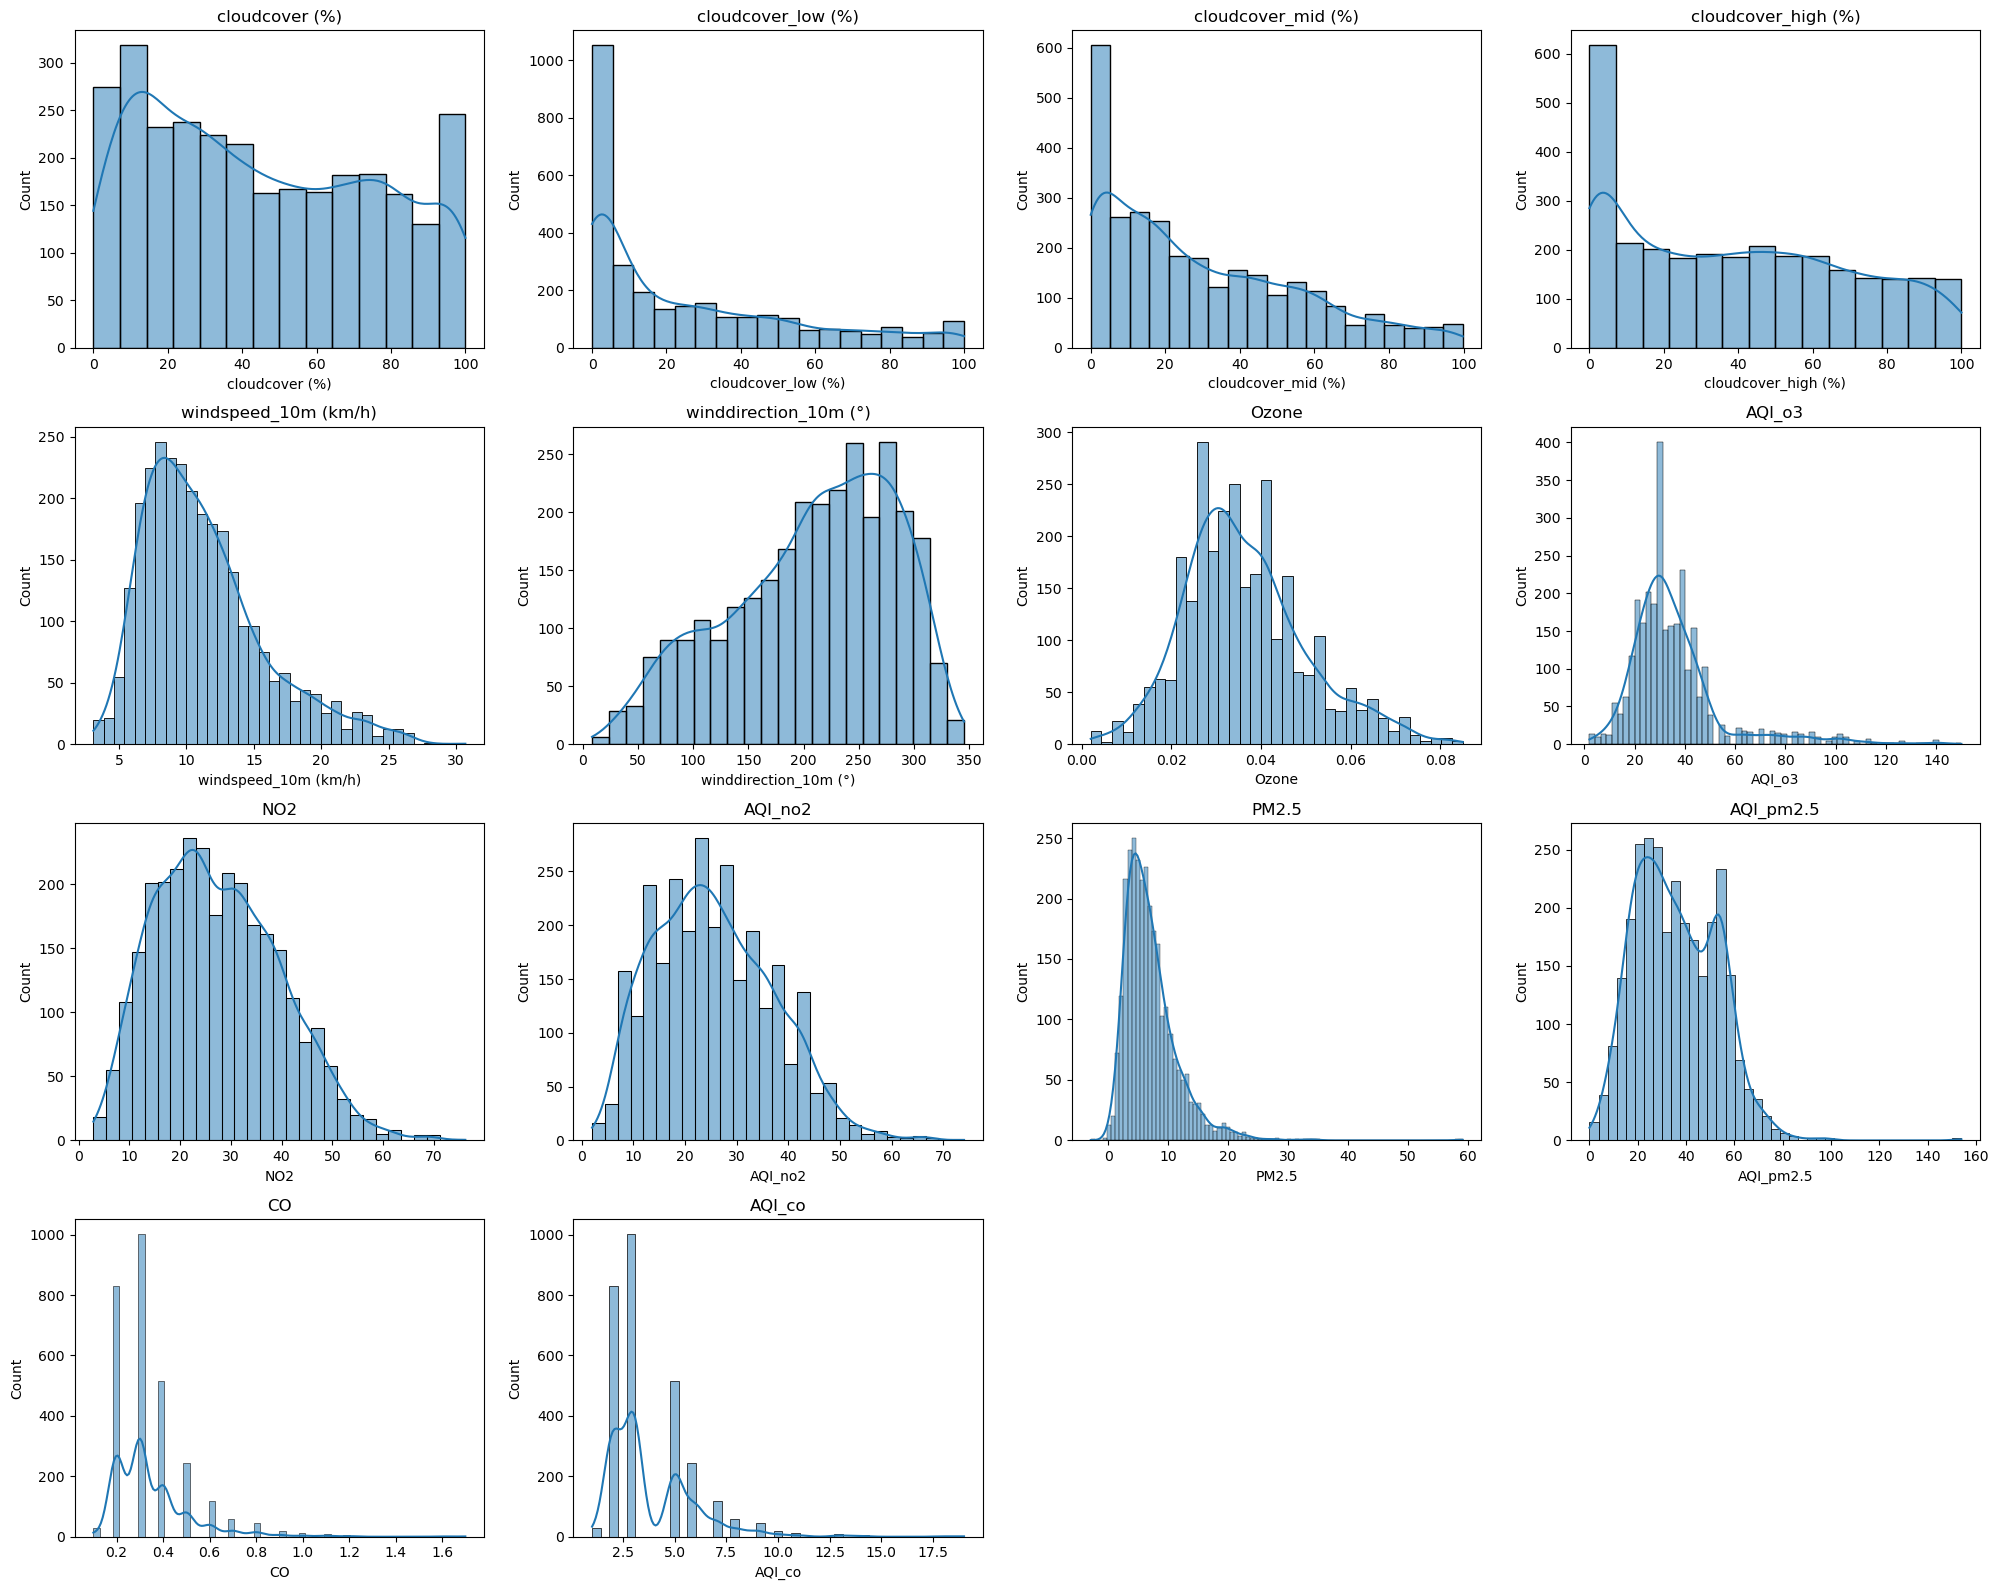

In [23]:
numeric_cols = merged_df.loc[:, ['cloudcover (%)', 'cloudcover_low (%)',
                     'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)',
                     'Ozone', 'AQI_o3', 'NO2', 'AQI_no2','PM2.5', 'AQI_pm2.5','CO', 'AQI_co'
                    ]].select_dtypes(include='number').columns # all numeric features without the lables, date, logtitune and latitude

# determine grid size
n_cols = 4 
n_rows = -(-len(numeric_cols) // n_cols)  


fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# plot each histogram
for i, col in enumerate(numeric_cols):
    sns.histplot(merged_df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Normaliza the Dataset ###

To ensure that no column dominates others due to its significantly larger value range—and at the same time preserve the relative distribution of values within each column—we will normalize the dataset using the Min-Max normalization algorithm. This will scale each column to a range between 0 and 1.

In [24]:
scaler = MinMaxScaler()

cols_to_normalize = ['cloudcover (%)', 'cloudcover_low (%)',
                     'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)',
                     'Ozone', 'AQI_o3', 'NO2', 'AQI_no2','PM2.5', 'AQI_pm2.5','CO', 'AQI_co'
                    ]

merged_df[cols_to_normalize] = scaler.fit_transform(merged_df[cols_to_normalize])
merged_df.tail()

,Date,County,Site Latitude,Site Longitude,Ozone,AQI_o3,NO2,AQI_no2,PM2.5,AQI_pm2.5,...,AQI_co,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
2891,2021-12-28,Queens,40.736,-73.822,0.108434,0.054054,0.387449,0.375000,0.247987,0.370130,...,0.277778,4.304167,0.091667,0.091667,0.761667,0.467917,0.645363,0.542500,0.173368,0.630706
2892,2021-12-28,Queens,40.736,-73.822,0.108434,0.054054,0.387449,0.375000,0.217391,0.350649,...,0.277778,4.304167,0.091667,0.091667,0.761667,0.467917,0.645363,0.542500,0.173368,0.630706
2893,2021-12-29,Queens,40.736,-73.822,0.132530,0.067568,0.260573,0.263889,0.322061,0.428571,...,0.277778,5.854167,0.212500,0.212500,0.943333,0.722917,0.514202,0.590000,0.115024,0.165780
2894,2021-12-29,Queens,40.736,-73.822,0.132530,0.067568,0.260573,0.263889,0.291465,0.402597,...,0.277778,5.854167,0.212500,0.212500,0.943333,0.722917,0.514202,0.590000,0.115024,0.165780
2895,2021-12-30,Bronx,40.868,-73.878,0.000000,0.000000,0.283765,0.277778,0.296296,0.409091,...,0.277778,6.954167,0.100000,0.100000,1.000000,0.926667,0.870927,0.509167,0.043531,0.438699


### Correlation Heatmap ###

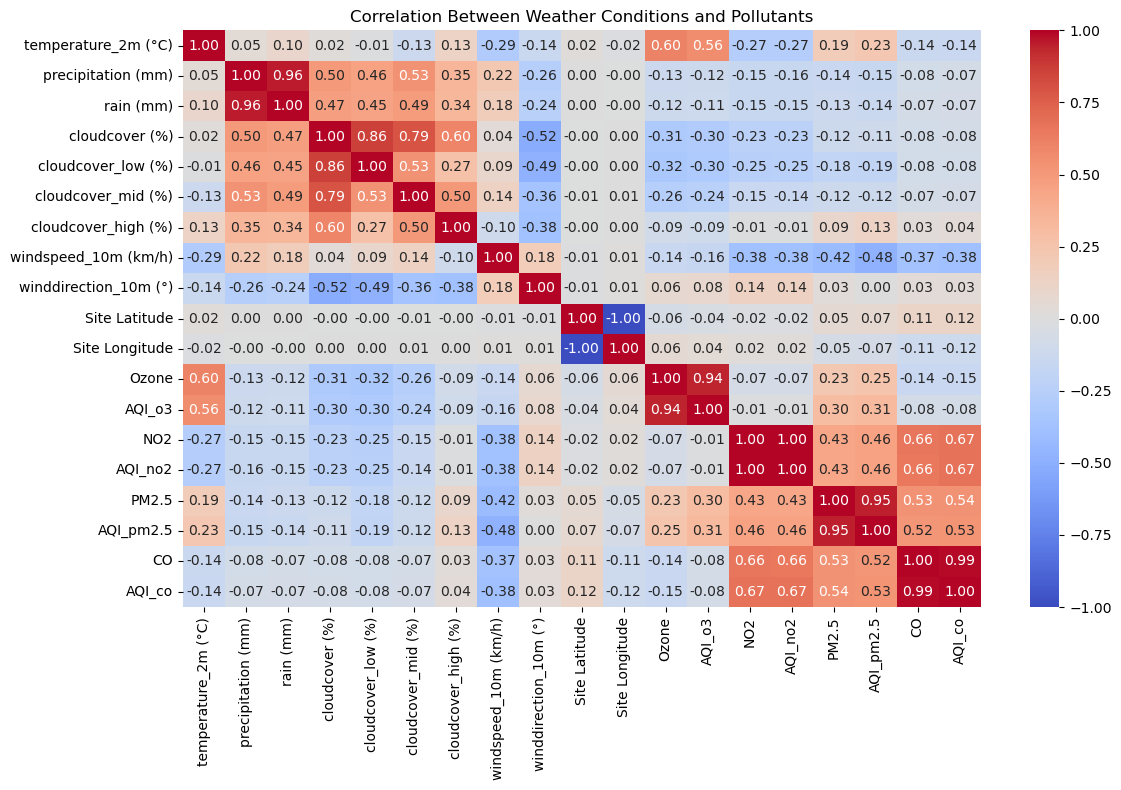

In [25]:
corr_df = merged_df[['temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)', 'cloudcover (%)',
                     'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)',
                     'Site Latitude', 'Site Longitude', 'Ozone', 'AQI_o3', 'NO2', 'AQI_no2', 'PM2.5', 'AQI_pm2.5', 'CO', 'AQI_co']]


plt.figure(figsize=(12, 8))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Between Weather Conditions and Pollutants')
plt.tight_layout()
plt.show()


#### Graph Conclusions ####

From the heatmap above, we can see a clear correlation between ozone and temperature, suggesting that ozone levels may influence temperature values. Moreover, there is noticeable correlation among the pollutants—for example, a correlation of nearly 0.7 between CO and NO₂. We also observe expected correlations among various weather factors, which aligns with our assumptions. Moreover, there is no correlation between any pollutant and rain/ precipitation - we will not include those label in our future ml model.

Next, we'll investigate the correlation between ozone and temperature alone in separate graph

### Correlation Between Ozone and Temperature ###

<Figure size 1000x600 with 0 Axes>

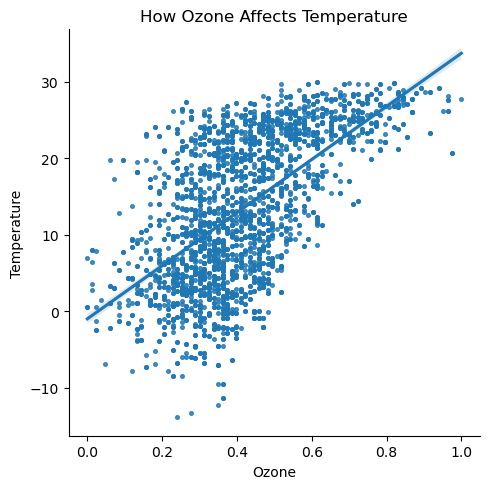

In [26]:
plt.figure(figsize=(10, 6))
sns.lmplot(x='Ozone', y='temperature_2m (°C)', data=merged_df,  scatter_kws={'s': 7})
plt.title('How Ozone Affects Temperature')
plt.xlabel('Ozone')
plt.ylabel('Temperature')
plt.tight_layout()
plt.show()


#### Graph Conclusions ####

In the graph above, we can observe a slight correlation between ozone and temperature. Specifically, when the temperature is low, ozone levels are also low, and as the temperature increases, ozone levels tend to rise as well.

### Comparison of Pollutant Levels in 2016, 2018, 2020, and 2021 ###

In [27]:
pollutants = ['Ozone', 'NO2', 'PM2.5', 'CO']

df = merged_df.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Year'] = df.index.year

# group by year and take mean
yearly_avg = df.groupby('Year')[pollutants].mean().reset_index()
yearly_avg

,Year,Ozone,NO2,PM2.5,CO
0,2016,0.408613,0.374982,0.158722,0.155834
1,2018,0.402387,0.342724,0.158039,0.157934
2,2020,0.410736,0.302102,0.144801,0.146351
3,2021,0.425904,0.310940,0.174824,0.153056


#### Boxplot Graph: Yearly Distribution of Pollutant Levels in NYC ####

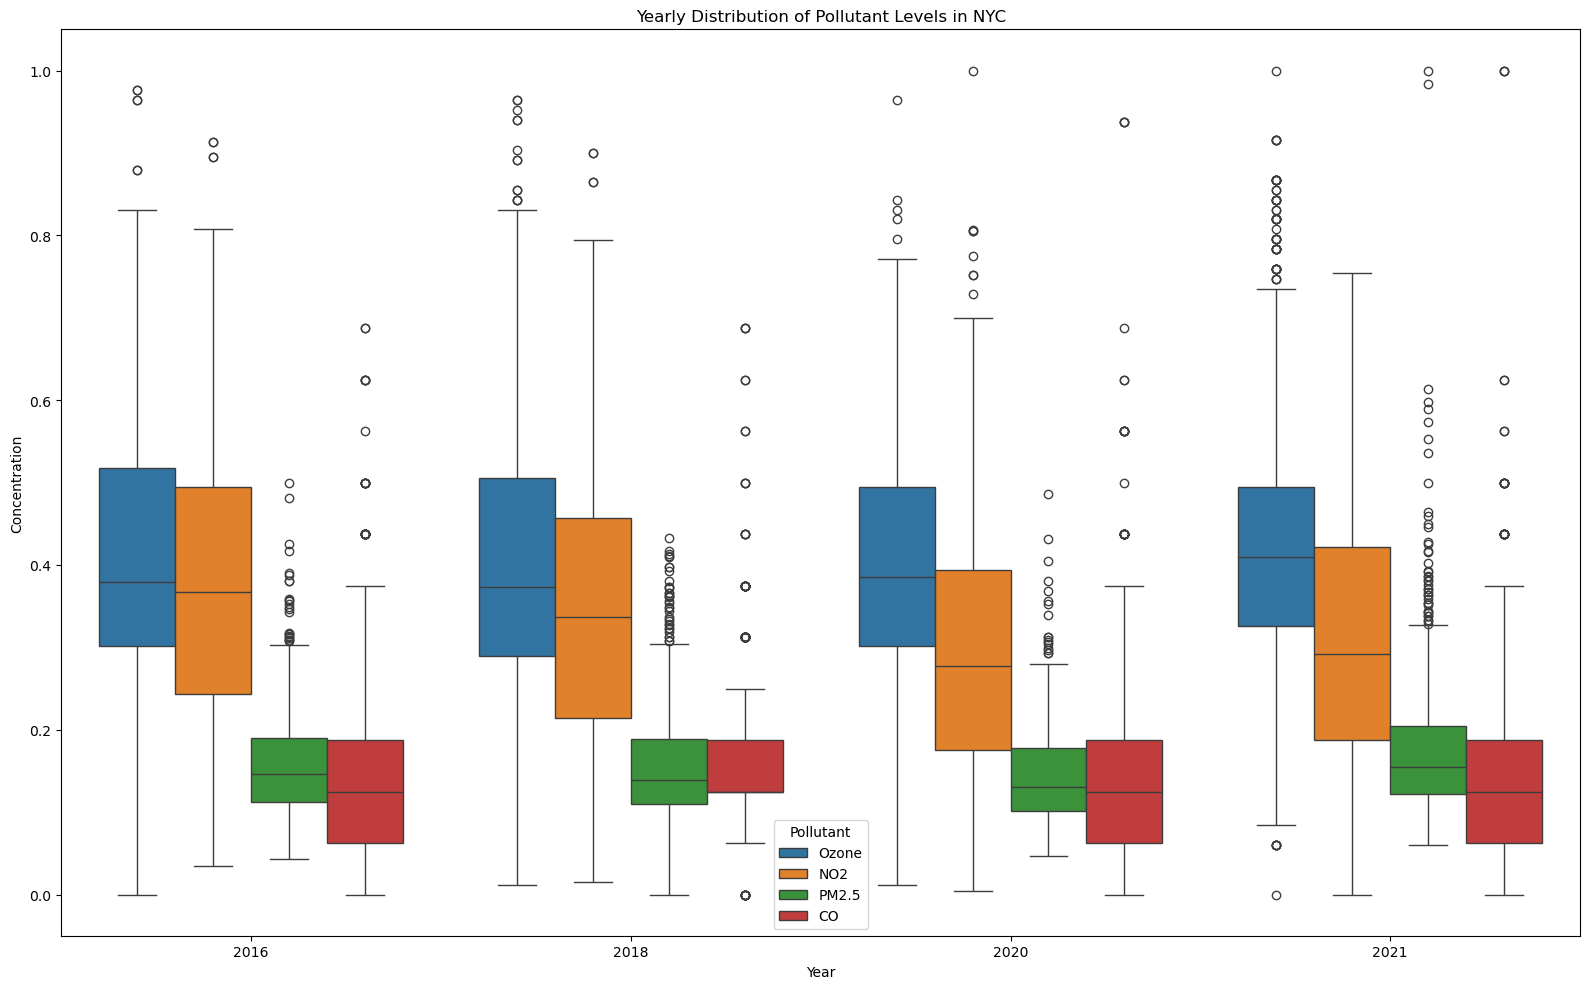

In [28]:
df = merged_df.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Year'] = df.index.year

pollutants = ['Ozone', 'NO2', 'PM2.5', 'CO']
df_long = df.melt(id_vars='Year', value_vars=pollutants, 
                  var_name='Pollutant', value_name='Concentration')

plt.figure(figsize=(16, 10))
sns.boxplot(data=df_long, x='Year', y='Concentration', hue='Pollutant')
plt.title('Yearly Distribution of Pollutant Levels in NYC')
plt.xlabel('Year')
plt.ylabel('Concentration')
plt.legend(title='Pollutant')
plt.tight_layout()
plt.show()

##### Graph Conclusions #####
As we can see from the boxplot above, the Q2 (median) and Q3 values of every pollutant in 2020 were lower than in the other years (2016, 2018, and 2021). This provides further visual evidence that during the peak of the COVID-19 pandemic, pollutant levels were lower compared to other years, suggesting that the lockdown had a significant impact on air pollution levels due to various factors such as reduced traffic, industrial slowdown, and decreased human activity. Moreover, we can see from the boxplots that there are many outliers.

#### Barplot Graph: Yearly Averages of Pollutants ####

In [29]:
melted_avg = yearly_avg.melt(id_vars='Year', var_name='Variable', value_name='Average')

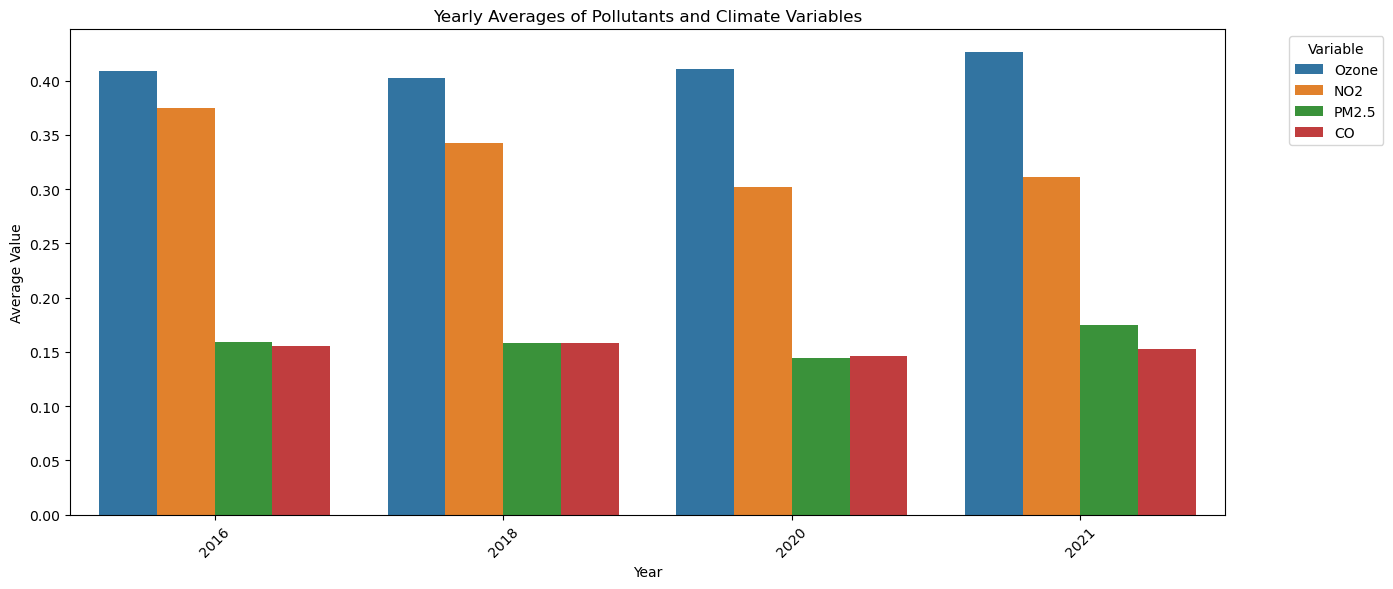

In [30]:
plt.figure(figsize=(14, 6))
sns.barplot(data=melted_avg, x='Year', y='Average', hue='Variable')
plt.title('Yearly Averages of Pollutants and Climate Variables')
plt.ylabel('Average Value')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##### Graph Conclusions #####

Just as we observed in the boxplot above, the barplot here also clearly shows that the average value of each individual pollutant was at its lowest in 2020. This supports our earlier discussion and further suggests that pollution levels significantly dropped during that year (pick COVID year).


## Feature Engineering & Selection ##

In [31]:
merged_df.shape

(2896, 21)

In [32]:
PRINT(f'Model current columns -> {merged_df.columns}')

--------------------------------------------------------------------------------------------------
Model current columns -> Index(['Date', 'County', 'Site Latitude', 'Site Longitude', 'Ozone', 'AQI_o3',
       'NO2', 'AQI_no2', 'PM2.5', 'AQI_pm2.5', 'CO', 'AQI_co',
       'temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)',
       'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)'],
      dtype='object')
--------------------------------------------------------------------------------------------------


One of the only issue remaining is with the Date column, which is currently in date format. If we want the model to learn from temporal patterns, we need to convert the date into a numeric format. To do this, we'll extract the Month from each date and apply one-hot encoding to represent it numerically.

Example:

* For January (Month 1), the encoded vector will be: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
* For July (Month 7), the encoded vector will be: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

We'll also use one-hot encoding in order to conver the day and year into numeric values.

In [33]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])


merged_df['month'] = merged_df['Date'].dt.month
merged_df['year'] = merged_df['Date'].dt.year
merged_df['weekday'] = merged_df['Date'].dt.day_name()  # e.g., 'Sunday'

# one-hot encode month
month_dummies = pd.get_dummies(merged_df['month'], prefix='', prefix_sep='').astype(int)
month_dummies.columns = [f'month_{i:02d}' for i in range(1, 13)]

# one-hot encode year
year_dummies = pd.get_dummies(merged_df['year'], prefix='year', prefix_sep='_').astype(int)

# one-hot encode weekday (Sunday first)
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekday_dummies = pd.get_dummies(merged_df['weekday'], dtype=int)
weekday_dummies = weekday_dummies.reindex(columns=weekday_order, fill_value=0)
weekday_dummies.columns = [f'day_{day[:3].lower()}' for day in weekday_dummies.columns]

# Drop original date-related columns
merged_df.drop(columns=['Date', 'month', 'year', 'weekday'], inplace=True)

# Combine all one-hot encoded columns with the original DataFrame
merged_df = pd.concat([merged_df, month_dummies, year_dummies, weekday_dummies], axis=1)

In [34]:
merged_df

,County,Site Latitude,Site Longitude,Ozone,AQI_o3,NO2,AQI_no2,PM2.5,AQI_pm2.5,CO,...,year_2018,year_2020,year_2021,day_sun,day_mon,day_tue,day_wed,day_thu,day_fri,day_sat
0,Bronx,40.868,-73.878,0.265060,0.135135,0.178718,0.180556,0.111111,0.142857,0.0625,...,0,0,0,0,0,0,0,0,1,0
1,Queens,40.736,-73.822,0.289157,0.148649,0.130969,0.125000,0.098229,0.116883,0.0625,...,0,0,0,0,0,0,0,0,1,0
2,Queens,40.736,-73.822,0.289157,0.148649,0.130969,0.125000,0.072464,0.058442,0.0625,...,0,0,0,0,0,0,0,0,1,0
3,Queens,40.736,-73.822,0.277108,0.141892,0.222374,0.222222,0.152979,0.240260,0.0625,...,0,0,0,0,0,0,0,0,0,1
4,Queens,40.736,-73.822,0.277108,0.141892,0.222374,0.222222,0.152979,0.240260,0.0625,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,Queens,40.736,-73.822,0.108434,0.054054,0.387449,0.375000,0.247987,0.370130,0.2500,...,0,0,1,0,0,1,0,0,0,0
2892,Queens,40.736,-73.822,0.108434,0.054054,0.387449,0.375000,0.217391,0.350649,0.2500,...,0,0,1,0,0,1,0,0,0,0
2893,Queens,40.736,-73.822,0.132530,0.067568,0.260573,0.263889,0.322061,0.428571,0.2500,...,0,0,1,0,0,0,1,0,0,0
2894,Queens,40.736,-73.822,0.132530,0.067568,0.260573,0.263889,0.291465,0.402597,0.2500,...,0,0,1,0,0,0,1,0,0,0


Next, we’ll use one-hot encoding to convert the `County` feature into a numeric column. As we saw earlier, only two counties remain in our dataset: Bronx and Queens.

In [35]:
county_dummies = pd.get_dummies(merged_df['County'], prefix='', prefix_sep='').astype(int)
county_dummies.columns = [f'county_{i:02d}' for i in range(1, 3)]
merged_df.drop(columns=['County'], inplace=True)

merged_df = pd.concat([merged_df, county_dummies], axis=1)

In [36]:
merged_df.head(2)

,Site Latitude,Site Longitude,Ozone,AQI_o3,NO2,AQI_no2,PM2.5,AQI_pm2.5,CO,AQI_co,...,year_2021,day_sun,day_mon,day_tue,day_wed,day_thu,day_fri,day_sat,county_01,county_02
0,40.868,-73.878,0.265060,0.135135,0.178718,0.180556,0.111111,0.142857,0.0625,0.055556,...,0,0,0,0,0,0,1,0,1,0
1,40.736,-73.822,0.289157,0.148649,0.130969,0.125000,0.098229,0.116883,0.0625,0.055556,...,0,0,0,0,0,0,1,0,0,1


In [37]:
merged_df.columns

Index(['Site Latitude', 'Site Longitude', 'Ozone', 'AQI_o3', 'NO2', 'AQI_no2',
       'PM2.5', 'AQI_pm2.5', 'CO', 'AQI_co', 'temperature_2m (°C)',
       'precipitation (mm)', 'rain (mm)', 'cloudcover (%)',
       'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)',
       'windspeed_10m (km/h)', 'winddirection_10m (°)', 'month_01', 'month_02',
       'month_03', 'month_04', 'month_05', 'month_06', 'month_07', 'month_08',
       'month_09', 'month_10', 'month_11', 'month_12', 'year_2016',
       'year_2018', 'year_2020', 'year_2021', 'day_sun', 'day_mon', 'day_tue',
       'day_wed', 'day_thu', 'day_fri', 'day_sat', 'county_01', 'county_02'],
      dtype='object')

#### KMeans Clustering for Latitude and Longitude ####

In [38]:
coords = merged_df[['Site Latitude', 'Site Longitude']]
kmeans = KMeans(n_clusters=2, random_state=42).fit(coords)
merged_df['cluster'] = kmeans.labels_

In [39]:
merged_df['cluster'].unique()

array([1, 0], dtype=int32)

In [40]:
merged_df.drop(columns=coords.columns, inplace=True)
merged_df.head()

,Ozone,AQI_o3,NO2,AQI_no2,PM2.5,AQI_pm2.5,CO,AQI_co,temperature_2m (°C),precipitation (mm),...,day_sun,day_mon,day_tue,day_wed,day_thu,day_fri,day_sat,county_01,county_02,cluster
0,0.265060,0.135135,0.178718,0.180556,0.111111,0.142857,0.0625,0.055556,5.408333,0.0,...,0,0,0,0,0,1,0,1,0,1
1,0.289157,0.148649,0.130969,0.125000,0.098229,0.116883,0.0625,0.055556,5.408333,0.0,...,0,0,0,0,0,1,0,0,1,0
2,0.289157,0.148649,0.130969,0.125000,0.072464,0.058442,0.0625,0.055556,5.408333,0.0,...,0,0,0,0,0,1,0,0,1,0
3,0.277108,0.141892,0.222374,0.222222,0.152979,0.240260,0.0625,0.055556,2.387500,0.0,...,0,0,0,0,0,0,1,0,1,0
4,0.277108,0.141892,0.222374,0.222222,0.152979,0.240260,0.0625,0.055556,2.387500,0.0,...,0,0,0,0,0,0,1,0,1,0


In [41]:
final_df = merged_df[['Ozone', 'AQI_o3', 'NO2', 'AQI_no2', 'PM2.5', 'AQI_pm2.5', 'CO',
       'AQI_co', 'cluster', 'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)',
       'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)',
       'month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06',
       'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12',
        'year_2018', 'year_2020', 'year_2021', 'day_sun', 'day_mon', 'day_tue',
       'day_wed', 'day_thu', 'day_fri', 'day_sat',
       'county_01', 'county_02', 'precipitation (mm)', 'rain (mm)', 'temperature_2m (°C)']]
final_df.head(2)

,Ozone,AQI_o3,NO2,AQI_no2,PM2.5,AQI_pm2.5,CO,AQI_co,cluster,cloudcover (%),...,day_tue,day_wed,day_thu,day_fri,day_sat,county_01,county_02,precipitation (mm),rain (mm),temperature_2m (°C)
0,0.265060,0.135135,0.178718,0.180556,0.111111,0.142857,0.0625,0.055556,1,0.572917,...,0,0,0,1,0,1,0,0.0,0.0,5.408333
1,0.289157,0.148649,0.130969,0.125000,0.098229,0.116883,0.0625,0.055556,0,0.572917,...,0,0,0,1,0,0,1,0.0,0.0,5.408333


In [42]:
final_df.rename(columns={'precipitation (mm)': 'precipitation', 'rain (mm)': 'rain', 'temperature_2m (°C)': 'temperature'}, inplace=True)

In [43]:
final_df.shape

(2896, 42)

In [44]:
final_df.to_csv(os.path.join('datasets', 'final_df.csv'), index=False)

## ML Model For Weather Prediction ##

### Model Building ###

In [5]:
from VISL import *

In [6]:
final_df = pd.read_csv(os.path.join('datasets', 'final_df.csv'))
df_columns = list(final_df.columns)
feature_cols = df_columns[:-3] # dont include precipitation, rain and temperature
label_cols = ['temperature']

### Train, Validate & Evaluate VISL Model - On temperature only ###


The next phase is to **train and validate the VISL model**. We will use the **Mean Squared Error (MSE)** loss function as the training criterion and the **Adam optimizer** for model optimization.

The model will then be evaluated using three metrics: **Mean Absolute Error (MAE)**, **Coefficient of Determination (R²)**, and **Explained Variance Score (EVS)**. Their mathematical definitions are as follows:

- **Mean Absolute Error (MAE)**:  
  $$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|$$

- **Coefficient of Determination (R²)**:  
  $$R^2 = 1 - \frac{\sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}{\sum_{i=1}^{n} \left( y_i - \bar{y} \right)^2}$$

- **Explained Variance Score (EVS)**:  
  $$\text{EVS} = 1 - \frac{\text{Var}(y - \hat{y})}{\text{Var}(y)}$$

After evaluating the VISL model, we will compare its performance against two baseline models: **Linear Regression** and **Random Foresst Regression**.


To evaluate the stability of our model, we will initialize and train 30 instances of the VISL model. The dataset will be shuffled and split using a ratio of 0.8, 0.1, and 0.1 for training, validation, and testing, respectively. Afterwards, we will compute statistical metrics such as the mean, variance, and standard deviation.

In [7]:
visl_res_dict = {'mae': [], 'r2': [], 'evs': []}

PRINT("Start training VISL models 10 times ...")
for i in range(10):
    model = VISL()
    
    train_ds, val_ds, test_ds = prepare_data(final_df, feature_cols, label_cols)
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)
    
    # train & evaluate model performance
    trained_model = train_model(model, train_loader, val_loader, epochs=150, lr=1e-3, weight_decay=1e-5)
    mae, r2, evs = evaluate_model(trained_model, test_loader)
    
    visl_res_dict['mae'].append(mae)
    visl_res_dict['r2'].append(r2)
    visl_res_dict['evs'].append(evs)

--------------------------------------------------------------------------------------------------
Start training VISL models 10 times ...
--------------------------------------------------------------------------------------------------


In [27]:
visl_evaluation_statistics = {'mae': [], 'r2': [], 'evs': []}

for k, v in visl_res_dict.items():
    # calculate metric mean, variance and std
    mean = np.mean(v)
    variance = np.var(v)
    std = np.std(v)

    visl_evaluation_statistics[k] = [round(float(x), 5) for x in [mean, variance, std]]

In [46]:
print(visl_evaluation_statistics)

VIST model metrics statistics after 10 train/val loops (mean, var, std):

{'mae': [1.384, 0.0078, 0.0886], 'r2': [0.9414, 0.0, 0.006], 'evs': [0.9433, 0.0, 0.0054]}


### Comparison with Existing Models: Linear Regression & Random Forest Regression ###

In [42]:
def train_baseline_models(df, feature_cols, label_cols):    
    lnr_res_dict = {'mae': [], 'r2': [], 'evs': []}
    rf_res_dict = {'mae': [], 'r2': [], 'evs': []}
    
    X = df[feature_cols].values
    y = df[label_cols].values

    for i in range(10):
        
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
        # initialize baseline bodels
        models = {
            "Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(n_estimators=60),
        }
        for name, model in models.items():
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            
            mae = round(mean_absolute_error(y_test, preds), 4)
            r2 = round(r2_score(y_test, preds), 4)
            evs = round(explained_variance_score(y_test, preds), 4)
            
            #print(f"{name}: MAE = {mae:.4f}, R²: {r2:.4f}, EVS: {evs:.4f}")
            if name == "Linear Regression":
                lnr_res_dict['mae'].append(mae)
                lnr_res_dict['r2'].append(r2)
                lnr_res_dict['evs'].append(evs)
            else:
                rf_res_dict['mae'].append(mae)
                rf_res_dict['r2'].append(r2)
                rf_res_dict['evs'].append(evs)
    
    return lnr_res_dict, rf_res_dict

# Compute stats for both models
def compute_stats(metrics_dict):
    stats = {}
    for k, v in metrics_dict.items():
        mean = round(float(np.mean(v)), 5)
        variance = round(float(np.var(v)), 5)
        std = round(float(np.std(v)), 5)
        stats[k] = [mean, variance, std]
    return stats

In [35]:
lnr_res_dict, rf_res_dict = train_baseline_models(final_df, feature_cols, label_cols)

In [43]:
lnr_stats = compute_stats(lnr_res_dict)
rf_stats = compute_stats(rf_res_dict)

In [71]:
def create_long_df(data_dict, model_name):
    data = []
    for i in range(10):
        for metric in ['mae', 'r2', 'evs']:
            data.append({
                'Fold': f'Fold {i+1}',
                'Metric': metric.upper(),
                'Score': data_dict[metric][i],
                'Model': model_name
            })
    return pd.DataFrame(data)

In [72]:
vist_df = create_long_df(visl_res_dict, 'VISL')
lnr_df = create_long_df(lnr_res_dict, 'Linear Regression')
rf_df = create_long_df(rf_res_dict, 'Random Forest')

# concat all data frames together
all_df = pd.concat([vist_df, lnr_df, rf_df], ignore_index=True)

In [74]:
# compare models mean performance by grouping by metric (e.g., MAE) and then by model (e.g., VISL)
PRINT('Comparison of models performance:')
all_df.groupby(['Metric', 'Model'])['Score'].mean()

--------------------------------------------------------------------------------------------------
Comparison of models performance:
--------------------------------------------------------------------------------------------------


Metric  Model            
EVS     Linear Regression    0.86430
        Random Forest        0.95565
        VISL                 0.94333
MAE     Linear Regression    2.51440
        Random Forest        1.22578
        VISL                 1.38404
R2      Linear Regression    0.86420
        Random Forest        0.95550
        VISL                 0.94137
Name: Score, dtype: float64

In [80]:
print(f'STATISTICS FORMAT (Mean, Varicance, STD)\n-----------------------------------------------------\nLiner Regression Statistics:\n{lnr_stats}\n\nRandom Forest Statistics:\n{rf_stats}\n\nVISL Model Statistics:\n{visl_evaluation_statistics}')

STATISTICS FORMAT (Mean, Varicance, STD)
-----------------------------------------------------
Liner Regression Statistics:
{'mae': [2.5144, 0.0, 0.0], 'r2': [0.8642, 0.0, 0.0], 'evs': [0.8643, 0.0, 0.0]}

Random Forest Statistics:
{'mae': [1.22578, 0.00034, 0.01855], 'r2': [0.9555, 0.0, 0.00107], 'evs': [0.95565, 0.0, 0.0011]}

VISL Model Statistics:
{'mae': [1.384, 0.0078, 0.0886], 'r2': [0.9414, 0.0, 0.006], 'evs': [0.9433, 0.0, 0.0054]}


#### Models Performance Conclusion ####


The **Linear Regression** model performed the weakest, with a high MAE of **2.5144** and no variation across runs, suggesting consistent but suboptimal performance.

The **Random Forest** model outperformed Linear Regression significantly, achieving a lower MAE of **1.2258** and a higher R² of **0.9555**, with minimal variance, indicating both strong and stable predictive power.

The **VIST model** demonstrated a solid balance between accuracy and generalization. With an MAE of **1.384** and R² of **0.9414**, it performed better than Linear Regression and approached Random Forest performance, showing moderate variability across runs, which reflects its flexibility and learning capacity across different splits.


### Evaluation Performance Visualization ###

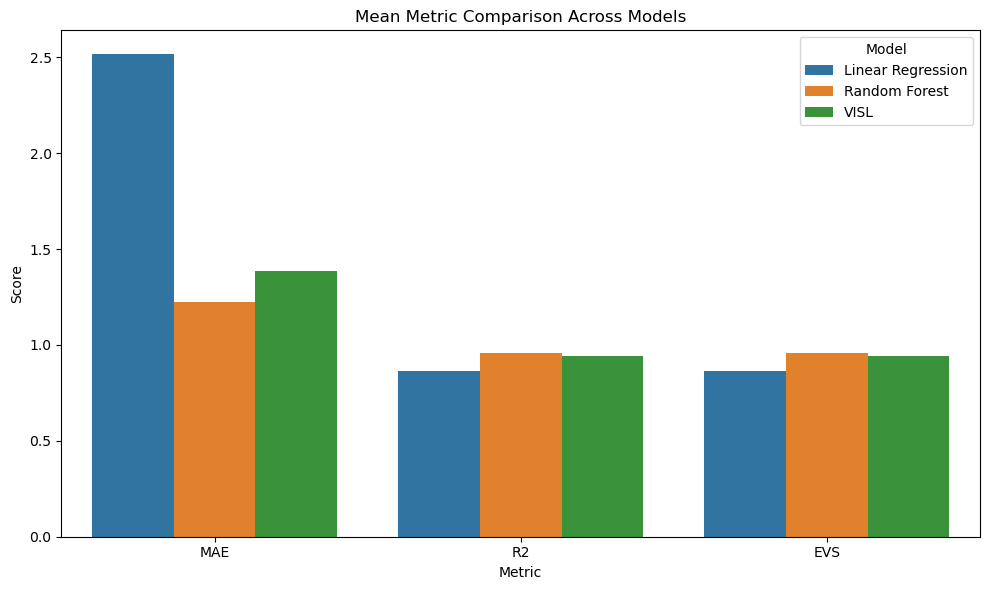

In [56]:
results = {'Linear Regression': lnr_stats, 'Random Forest': rf_stats, 'VISL': visl_evaluation_statistics}
plot_data = []

for model, stats in results.items():
    for metric, statistics_ls in stats.items():
        mean, var, std = statistics_ls
        plot_data.append({'Model': model, 'Metric': metric.upper(), 'Stat': 'Mean', 'Value': mean})

df_plot = pd.DataFrame(plot_data)

# barplot: Mean values
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot[df_plot['Stat'] == 'Mean'], x='Metric', y='Value', hue='Model')
plt.title('Mean Metric Comparison Across Models')
plt.ylabel('Score')
plt.legend(title='Model')
plt.tight_layout()
plt.show()